# Initialize Robot

In [161]:
print("RUNin")
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseKinematics,
    KinematicTrajectoryOptimization,
    InverseDynamicsController,
    PidController,
    MeshcatVisualizer,
    MathematicalProgram,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    Solve,
    StartMeshcat,
    RigidTransform,
    RollPitchYaw,
    PiecewisePolynomial,
    TrajectorySource,
    Solve,
    RotationMatrix,
    eq,
    JointIndex
)
from pydrake.trajectories import PiecewisePolynomial
from underactuated.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
from underactuated import running_as_notebook

import os

RUNin


In [162]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7020


# Defining Walking Gait

In [163]:
def rotation(yaw, pitch, roll):
    return np.array(((np.cos(pitch) * np.cos(roll), np.sin(yaw) * np.sin(pitch) * np.cos(roll) - np.cos(yaw) * np.sin(roll), np.cos(yaw) * np.sin(pitch) * np.cos(roll) + np.sin(yaw) * np.sin(roll)),
        (np.cos(pitch) * np.sin(roll), np.sin(yaw) * np.sin(pitch) * np.sin(roll) + np.cos(yaw) * np.cos(roll), np.cos(yaw) * np.sin(pitch) * np.sin(roll) - np.sin(yaw) * np.sin(roll)),
        (-np.sin(pitch), np.sin(yaw) * np.cos(pitch), np.cos(yaw) * np.cos(pitch))))

def create_gait(direction, radius, yaw, speed, height, dutyCycle, gateNum, gateType):
    '''
    Defines walking gate pattern for all legs.
    '''
    inc = 0.01
    bodyAngles = [(math.pi/3) * (.5+l) for l in range(6)]
    # Initializes t, the parametric parameter as 0 <= t < 2pi
    t_s = np.arange(0, dutyCycle*math.pi, inc)
    t_r = np.arange(dutyCycle*math.pi, (2 - dutyCycle) * math.pi, inc)
    t_f = np.arange((2 - dutyCycle) * math.pi, 2* math.pi, inc)

    # Creates the basic untransformed version of the walking pattern
    walkStart = np.array((- speed * t_s / (2 * dutyCycle * math.pi),[0] * len(t_s), [0] * len(t_s)))
    walkReset = np.array((- (speed / 2) * np.cos((t_r - dutyCycle * math.pi) / (2 - 2 * dutyCycle)), [0] * len(t_r), height * np.sin((t_r - dutyCycle * math.pi) / (2 - 2 * dutyCycle))))
    walkFinish = np.array((speed / (2 * dutyCycle * math.pi) * (2 * math.pi - t_f), [0] * len(t_f), [0] * len(t_f)))

    walkBasic = np.concatenate((walkStart.T, walkReset.T, walkFinish.T), axis=0)

    # Rotates the walk to the correct direction
    walkRotated = np.matmul(walkBasic, rotation(direction, 0, 0))

    # Creates 6 Duplicates for each leg
    allStart = np.array([(radius * np.cos(ang + yaw), radius * np.sin(ang + yaw), 0) for ang in bodyAngles])
    walkAll = [np.add(allStart, walkR) for walkR in walkRotated]
    #print(walkAll)

    # Change gate info
    # num, name = gateType.split("_")
    gateLen = np.shape(walkAll)[0]
    phaseShift = gateLen / gateNum
    #print(phaseShift)

    match gateType:
        case "1_Wave":    shift = [0,1,2,3,4,5]
        case "1_Ripple":  shift = [0,5,4,3,2,1]
        case "2_Opst":    shift = [0,2,4,0,2,4]
        case "2_Ripple":  shift = [0,2,4,2,0,4]
        case "2_Worm":    shift = [0,2,4,2,4,0]
        case "3_TriPod":  shift = [0,3,0,3,0,3]
        case "3_Waddle":  shift = [0,0,0,3,3,3]

    gateShift = (np.array(shift) * phaseShift).astype(int)
    print(gateShift)

    walkAll = np.array(walkAll)
    #for each leg do the shift
    
    #walkAll = np.roll(walkAll, 280, 0)

    for i in range(6):
        walkAll[:,i,:] = np.roll(walkAll[:,i,:], gateShift[i], 0)
    # walkShift = []
    # for i in range(6):
    #     walkShift.append(np.roll(walkAll[i], gateShift[i], axis=0))
    # print(np.array(walkShift).shape)

    # walkAll = np.roll(walkAll, gateShift, 0)
    return walkAll

[  0 314   0 314   0 314]
[(0.0, 0, 255.0), (2.5757575757575757, 0, 252.42424242424244), (5.151515151515151, 0, 249.84848484848484), (7.727272727272727, 0, 247.27272727272728), (10.303030303030303, 0, 244.6969696969697), (12.878787878787879, 0, 242.12121212121212), (15.454545454545453, 0, 239.54545454545456), (18.03030303030303, 0, 236.96969696969697), (20.606060606060606, 0, 234.3939393939394), (23.18181818181818, 0, 231.8181818181818), (25.757575757575758, 0, 229.24242424242425), (28.333333333333332, 0, 226.66666666666666), (30.909090909090907, 0, 224.0909090909091), (33.484848484848484, 0, 221.5151515151515), (36.06060606060606, 0, 218.93939393939394), (38.63636363636363, 0, 216.36363636363637), (41.21212121212121, 0, 213.78787878787878), (43.78787878787879, 0, 211.21212121212122), (46.36363636363636, 0, 208.63636363636363), (48.93939393939394, 0, 206.06060606060606), (51.515151515151516, 0, 203.4848484848485), (54.090909090909086, 0, 200.9090909090909), (56.666666666666664, 0, 198.

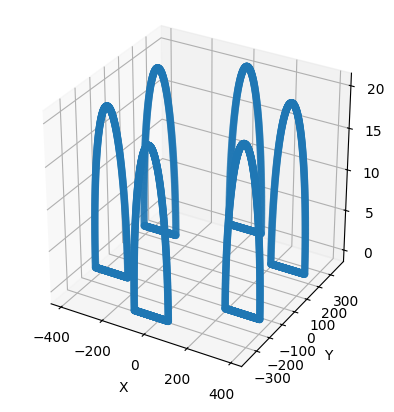

In [164]:
walks = create_gait(0, 360, 0, 160, 20, .4, 6, "3_TriPod")
#print(walks)
ax = plt.figure().add_subplot(projection='3d')
walkx, walky, walkz = [], [], []
grad = np.linspace(0, 255, 100)
c_list = [(g, 0 , 255-g) for g in grad]
print(c_list)
for walk in walks:
    for w in walk:
        walkx.append(w[0])
        walky.append(w[1])
        walkz.append(w[2])

ax.set_box_aspect([1,1,1])
ax.scatter(walkx, walky, walkz) #, c=c_list[1])
# Add labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

walks_np = np.array(walks)


In [165]:
print(walks_np.shape)
print(walks_np[:,2,:])

(629, 6, 3)
[[-311.76914536  180.            0.        ]
 [-312.40576513  180.            0.        ]
 [-313.04238491  180.            0.        ]
 ...
 [-310.07337736  180.            0.        ]
 [-310.70999714  180.            0.        ]
 [-311.34661691  180.            0.        ]]


# TrajOpt to Obtain Joint Angles: run  this one for fixed body

In [166]:
def BuildAndSimulateTrajectory(q_traj, duration, start_q0):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    """
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    hex_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "file:///work/Hex_centered/hull_vis.urdf"
    #/work/Hex_model_assembly_jank_one_leg_file_mv/Hex_model_assembly_jank_one_leg.urdf
    )[0]

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))

    plant.Finalize()
    print("finalized plant")

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Adds an approximation of the iiwa controller.
    # TODO(russt): replace this with the joint impedance controller.
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    hex_controller = builder.AddSystem(
        PidController(kp, ki, kd)  # Apply saturation limits to the output
    )
    hex_controller.set_name("hex_controller")
    builder.Connect(
        plant.get_state_output_port(),
        hex_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
    )


    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))

    builder.Connect(
        q_traj_system.get_output_port(), iiwa_controller.GetInputPort("desired_state")
    )

    diagram = builder.Build()
    diagram.set_name("with hex controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = start_q0
    x0 = np.hstack((q0, 0 * q0))
    plant.SetPositions(plant_context, q0)
    print("about to start sim")


    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration if running_as_notebook else 0.1);
    visualizer.PublishRecording()

    return simulator, plant

In [177]:
def CreateHexControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""

    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    """
    builder = DiagramBuilder()
    
    import os


    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    urdf_path = "Hex_centered/hull_vis.urdf"
    Parser(plant, scene_graph).AddModels(urdf_path)
    #/work/Hex_model_assembly_jank_one_leg_file_mv/Hex_model_assembly_jank_one_leg.urdf

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))

    plant.Finalize()
    print("finalized plant")

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Adds an approximation of the iiwa controller.
    # TODO(russt): replace this with the joint impedance controller.
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    iiwa_controller = builder.AddSystem(
        PidController(kp, ki, kd)  # Apply saturation limits to the output
    )
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(),
        iiwa_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
    )


    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.zeros(18)
    plant.SetPositions(plant_context, q0)

    return plant, context, plant_context

CreateHexControllerPlant()

finalized plant


(<pydrake.multibody.plant.MultibodyPlant at 0x7d0b144dc9b0>,
 <pydrake.systems.framework.LeafContext at 0x7d0b171b84b0>)

In [181]:
def create_q_knots(t_lst, walks_np, z_height = -0.1):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: t_lst: time steps, walks: ik info
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, context, plant_context = CreateHexControllerPlant()
    #world_frame = plant.world_frame()
    #gripper_frame = plant.GetFrameByName("weld_point")
    q_nominal = np.zeros(18)
    # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    point_list = np.zeros([3,1])
    iiwa_pos_list = []
    iiwa_world_pos_list = []

    base_frame = plant.GetFrameByName("base_link")
    leg0_end_frame = plant.GetFrameByName("leg0_end")
    leg1_end_frame = plant.GetFrameByName("leg1_end")
    leg2_end_frame = plant.GetFrameByName("leg2_end")
    leg3_end_frame = plant.GetFrameByName("leg3_end")
    leg4_end_frame = plant.GetFrameByName("leg4_end")
    leg5_end_frame = plant.GetFrameByName("leg5_end")

    leg_frames = [leg0_end_frame, leg1_end_frame, leg2_end_frame, leg3_end_frame, leg4_end_frame, leg5_end_frame]

    for i in range(len(t_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        ################################################


        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q_nominal, q)

        for leg_index in range(6):
            this_leg_frame = leg_frames[leg_index]

            speed_mult = 5

            des_x, des_y, des_z = walks_np[(speed_mult*i) % 630,leg_index,:]*0.001
            des_z += z_height
            des_pos = np.array((des_x, des_y, des_z))
            ik.AddPositionConstraint(
                frameA=base_frame,
                frameB=leg_frames[leg_index],
                p_BQ=np.zeros(3),
                p_AQ_lower=des_pos-np.array([0.01, 0.01, 0.01]),
                p_AQ_upper=des_pos+np.array([0.01, 0.01, 0.01]),
            )

        if i == 0:
            prog.SetInitialGuess(q, q_nominal)
        else:
            prog.SetInitialGuess(q, last_solution)
        result = Solve(prog)
        print(result.is_success())

        if not result.is_success():
            return None
        
        last_solution = result.GetSolution(q_variables)
        q_knots.append(last_solution)

        plant.SetPositions(plant_context, last_solution)


    return q_knots

# Run this one to sim on ground

In [169]:
def BuildAndSimulateTrajectory(q_traj, duration, q_start):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 1e-3)
    parser = Parser(plant)

    %pwd
    urdf_path = "Hex_centered/hull_vis.urdf"
    Parser(plant, scene_graph).AddModels(urdf_path)

    Parser(plant, scene_graph).AddModels("floor.sdf")
    plant.Finalize()

    # Add a PD Controller
    kp = 100*np.ones(18)#1
    ki = 0.0*np.ones(18)
    kd = .1*np.ones(18)
    # Select the joint states (and ignore the floating-base states)
    S = np.zeros((36, 49))
    num_q = plant.num_positions()
    j = 0
    for i in range(plant.num_joints()):
        joint = plant.get_joint(JointIndex(i))
        if joint.num_positions() != 1:
            continue
        S[j, joint.position_start()] = 1
        S[18+j, num_q + joint.velocity_start()] = 1

        j = j+1

    control = builder.AddSystem(PidController(
        kp=kp, ki=ki, kd=kd,
        state_projection=S,
        output_projection=plant.MakeActuationMatrix()[6:,:].T))

    builder.Connect(plant.get_state_output_port(), control.get_input_port_estimated_state())
    builder.Connect(control.get_output_port(), plant.get_actuation_input_port())

    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph,
                                                   meshcat)

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))

    builder.Connect(
        q_traj_system.get_output_port(), control.get_input_port_desired_state()
    )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)
    x0 = S @ plant.get_state_output_port().Eval(plant_context)


    # control.get_input_port_desired_state().FixValue(
    #     control.GetMyContextFromRoot(context), x0)


    q0 = plant.GetPositions(plant_context)
    #set z height
    q0[6] = 0.2
    plant.SetPositions(plant_context, q0)

    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0)
    visualizer.StartRecording()
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()
    return simulator, plant

In [170]:
duration = 10
t_lst = np.linspace(0, duration, 630)

speed = 180
walks_np = np.array(create_gait(0, 360, 0, speed, 20, .4, 6, "3_TriPod"))

q_knots = np.array(create_q_knots(t_lst, walks_np, -0.05))

inital_q_knot = q_knots[0]

double_q_knots = np.hstack((q_knots, q_knots*0))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, double_q_knots.T)

print(q_traj)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, duration, inital_q_knot)

[  0 314   0 314   0 314]
Current working directory: /home/hexbot/Documents/Hex_inv_kin
Notebook directory: /home/hexbot/Documents/Hex_inv_kin
finalized plant


-1.0
[  0 314   0 314   0 314]
finalized plant
-0.8
[  0 314   0 314   0 314]
finalized plant
-0.6000000000000001
[  0 314   0 314   0 314]
finalized plant
-0.40000000000000013
[  0 314   0 314   0 314]
finalized plant
-0.20000000000000018
[  0 314   0 314   0 314]
finalized plant
-2.220446049250313e-16
[  0 314   0 314   0 314]
finalized plant
0.19999999999999973
[  0 314   0 314   0 314]
finalized plant
0.3999999999999997
[  0 314   0 314   0 314]
finalized plant
0.5999999999999996
[  0 314   0 314   0 314]
finalized plant
0.7999999999999996
[  0 314   0 314   0 314]
finalized plant


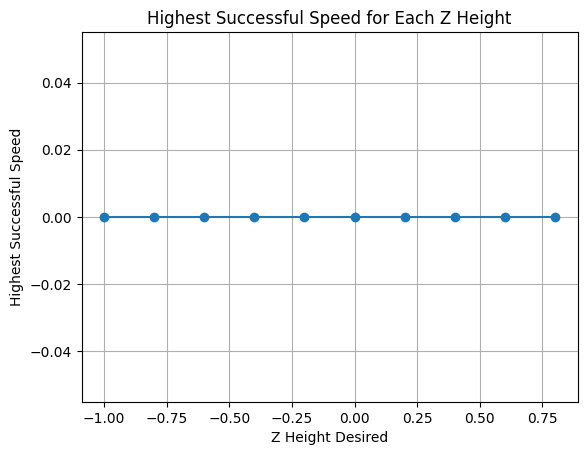

In [186]:
duration = 10
t_lst = np.linspace(0, duration, 630)

# Define the range of z_height_des
z_height_des_range = np.arange(-1.0, 1.0, 0.2)

# Initialize a dictionary to store highest successful speed for each z_height_des
max_speeds = {}

for z_height_des in z_height_des_range:
    print(z_height_des)
    max_speed = 0  # Initialize max_speed for this z_height_des
    for speed in range(120, 300, 20):
        walks_np = np.array(create_gait(0, 360, 0, speed, 20, .4, 6, "3_TriPod"))
        q_knots = np.array(create_q_knots(t_lst, walks_np, z_height_des))
        print(q_knots)
        # Check if the motion is successful, you need to implement a condition for success
        if q_knots != None:
            max_speed = speed
            print("yay")
        else:
            break  # If motion fails, break the loop
    max_speeds[z_height_des] = max_speed  # Store the max_speed for this z_height_des

# Plotting the results
plt.plot(max_speeds.keys(), max_speeds.values(), marker='o')
plt.xlabel('Z Height Desired')
plt.ylabel('Highest Successful Speed')
plt.title('Highest Successful Speed for Each Z Height')
plt.grid(True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cf6b6c5-207c-4950-ac95-04e05075ef7a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>